# Intrinsic (Neural) Timescales

### What are Intrinsic Timescales?

- An indicator of Temporal Receptive Windows (TRWs) (Hasson et al., 2008; Honey et al., 2012)
- Estimated as the decay rate of autocorrelation function (or something analogous to it)

### What is IntrinsicTimescales.jl?

- A Julia package to estimate to estimate Intrinsic (Neural) Timescales (INTs)
- Documentation is [here](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/home/)

### How does it work?

- You give your data to `acw` function and it takes care of the rest. 

Due to time limitations, we will only cover the basics here in this workshop: Installation, basic usage and interoperability with Python. 

## Quick Intro to Julia

IntrinsicTimescales.jl is written in Julia and it is best used from Julia. Why not Python or MATLAB? The cutting edge techniques to estimate timescales (Bayesian methods) require thousands of simulations and MATLAB/Python are too slow for this kind of job. 

The syntax of Julia should be familiar to Python/MATLAB users: (e.g.) You index with square brackets like Python but indexing starts from 1 like MATLAB. 

You will need vanishingly small Julia programming to use IntrinsicTimescales.jl, in particular, we will cover interoperability with MNE. 

At the end, we will also talk about using Julia from inside Python (though experimental).

If you never used Julia or haven't installed it, you can install it from [https://julialang.org/install/](https://julialang.org/install/). If you would like to get familiar with it, the best place to start is [Modern Julia Workflows](https://modernjuliaworkflows.org/).

## Installing IntrinsicTimescales.jl

Create an empty directory on your pc. 
From Julia REPL, cd into the empty directory, for example, on my PC:

```julia
cd(raw"C:\Users\yasir\Desktop\brain_stuff\workshop2025") # raw is the equivalent of r"" in Python
```

Then use the package manager of Julia to install the packages we will use.

```julia
using Pkg
Pkg.activate(".") # activate current folder (i.e. create an environment here)
Pkg.add(["IntrinsicTimescales", "Plots", "PythonCall"])
```

The packages other than IntrinsicTimescales.jl we are going to use:

- `Plots`: for plotting
- `PythonCall`: Using IntrinsicTimescales.jl from Python (next tutorial). 

Now put this .ipynb notebook in the same folder and select your Julia environment to use it 

(example: I use Cursor, a VSCode fork and you pick Julia environment from lower left corner)

![](assets/juliaenv.png)

Now we can use Julia inside Jupyter. Use the code below to import any package we want:

In [1]:
using IntrinsicTimescales

For this tutorial, let's use simulated data. `IntrinsicTimescales.jl` has two data simulation functions, `generate_ou_process` and `generate_ou_with_oscillation` (to simulate oscillatory artifacts). We'll use `generate_ou_process` here for simplicity. 

In [4]:
# See the help of `generate_ou_process`
@doc generate_ou_process

```
generate_ou_process(tau, true_D, dt, duration, num_trials; standardize=true, rng=Random.default_rng(), deq_seed=nothing)
```

Generate an Ornstein-Uhlenbeck process with a single timescale

# Arguments

  * `tau::Union{Real, Vector{<:Real}}`: Timescale(s) of the OU process
  * `true_D::Real`: Target variance for scaling the process
  * `dt::Real`: Time step size
  * `duration::Real`: Total time length
  * `num_trials::Real`: Number of trials/trajectories
  * `standardize::Bool=true`: Whether to standardize output to match true_D
  * `rng::AbstractRNG=Random.default_rng()`: Random number generator for initial conditions
  * `deq_seed::Integer=nothing`: Random seed for DifferentialEquations.jl solver. If `nothing`, uses StochasticDiffEq.jl defaults. Note that for full replicability,

you need to set both `rng` and `deq_seed`. 

# Returns

  * Matrix{Float64}: Generated OU process data with dimensions (num*trials, num*timesteps)

# Notes

  * Uses generate*ou*process_sciml internally
  * Returns NaN matrix if SciML solver fails
  * Standardizes output to have specified variance if standardize=true


In [10]:
timescale = 0.01
variance = 1.0
dt = 1 / 1000
duration = 10.0 # 10 seconds
num_trials = 5
data = generate_ou_process(timescale, variance, dt, duration, num_trials)
println(size(data)) 

(5, 10000)


The data we simulated has 5 trials (first dimension) and 10000 time points (second dimension). The general function to calculate INTs is `acw`, which is super simple to use. The full documentation of the function is [here](https://duodenum96.github.io/IntrinsicTimescales.jl/stable/acw/). 

In [11]:
fs = 1 / dt # Sampling rate
results = acw(data, fs, acwtypes=[:acw50, :tau, :knee]) # you can use any acwtypes you want here

ACWResults(1000.0, [[0.007, 0.008, 0.007, 0.007, 0.008], [0.009560944097618412, 0.010568730358960178, 0.009401368845062619, 0.009766431040991638, 0.010382147389628704], [0.008393414115558414, 0.01042520889840708, 0.009251719470208841, 0.008926686340150163, 0.009873801274490824]], [:acw50, :tau, :knee], 100, (0.1, 500.0), [1.0 0.9104144553328843 … -0.03154116096225716 -0.031049223916544244; 1.0 0.9133478819880744 … -0.00881545181926211 -0.010886376560632753; … ; 1.0 0.908257588098397 … 0.022042797597084825 0.02663843271892997; 1.0 0.9167737199637909 … 0.052812589843628514 0.05118099781199431], [0.041790708697962205 0.02804728596189756 … 1.054480557490134e-5 0.00013072742839517887; 0.031149477290805624 0.03639061917287868 … 1.99981091347401e-5 1.8488745931295295e-5; … ; 0.009615726783598257 0.015829960532214055 … 4.394741128691027e-5 9.864702827302699e-5; 0.03884868904589352 0.08911723253812374 … 0.0003443743066548089 0.00015986015427823353], [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6

Let's investigate the  `results` structure. From the cell above, we can see that it is a seperate data format called `ACWResults`. 

In [13]:
@doc ACWResults

```
ACWResults
```

Structure holding ACW analysis inputs and results.

# Fields

  * `fs::Real`: Sampling frequency
  * `acw_results`: Computed ACW values (type depends on number of ACW types requested)
  * `acwtypes::Union{Vector{<:Symbol}, Symbol}`: Types of ACW computed
  * `n_lags::Union{Int, Nothing}`: Number of lags used for ACF calculation
  * `freqlims::Union{Tuple{Real, Real}, Nothing}`: Frequency limits used for spectral analysis
  * `acf::Union{AbstractVector{<:Real}, AbstractArray{<:Real}, Nothing}`: Autocorrelation function
  * `psd::Union{AbstractVector{<:Real}, AbstractArray{<:Real}, Nothing}`: Power spectral density
  * `freqs::Union{AbstractVector{<:Real}, AbstractArray{<:Real}, Nothing}`: Frequency vector for PSD
  * `lags::Union{AbstractVector{<:Real}, AbstractArray{<:Real}, Nothing}`: Lag vector for ACF
  * `x_dim::Union{Int, Nothing}`: Dimension index corresponding to x-axis (lags/freqs)

# Notes

  * Supported ACW types: :acw0, :acw50, :acweuler, :auc, :tau, :knee
  * Results order matches input acwtypes order
  * If only one ACW type is requested, `acw_results` is a scalar; otherwise it's a vector


In [14]:
results.acw_results

3-element Vector{Vector{Float64}}:
 [0.007, 0.008, 0.007, 0.007, 0.008]
 [0.009560944097618412, 0.010568730358960178, 0.009401368845062619, 0.009766431040991638, 0.010382147389628704]
 [0.008393414115558414, 0.01042520889840708, 0.009251719470208841, 0.008926686340150163, 0.009873801274490824]

We can see that it is a vector of 3 elements. Each element corresponds to one `acwtype` we specified above (`acwtypes=[:acw50, :tau, :knee]`). Let's look into the second element `tau` which directly corresponds to the `timescale`. 

In [15]:
println(results.acw_results[2])

[0.009560944097618412, 0.010568730358960178, 0.009401368845062619, 0.009766431040991638, 0.010382147389628704]


5 elements, corresponding to 5 trials and all of them are very close to the original timescale `0.01`. IntrinsicTimescales.jl also comes with fancy plotting capabilities in the form of `acwplot`. 

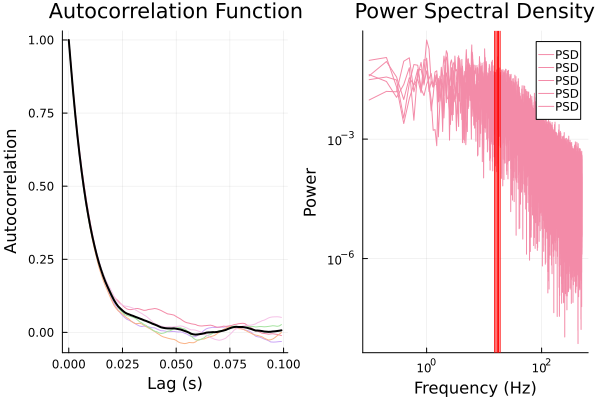

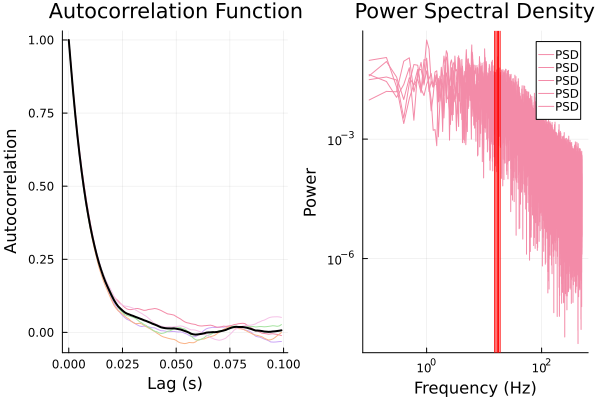

In [18]:
using Plots # We need to import the plotting library to use this
acwplot(results)

On the left side, we see the autocorrelation function. Various ACW metrics like `ACW-50`, `tau` etc. are calculated from this. The right side shows the power spectrum. By a mathematical theorem called Wiener-Khinchine theorem, the PSD and ACF are related by Fourier transforms. This means that every information encoded in ACF is also encoded in PSD and vice versa. The decay rate of the autocorrelation function `:tau` corresponds to the knee frequency (the frequency where you switch from a flat horizontal line to a line with a slope, `:knee`) up to a multiplicative constant. In the plot to the right, this is indicated by vertical bars (for each trial). If we look into the timescales estimated by knee frequency method (see [Gao et al., 2020](https://elifesciences.org/articles/61277)):

In [19]:
results.acw_results[3]

5-element Vector{Float64}:
 0.008393414115558414
 0.01042520889840708
 0.009251719470208841
 0.008926686340150163
 0.009873801274490824

We can see that they also recover the original timescale `0.01` very closely. 

Okay, but how does `acw` know which dimension is trials and which dimension is time points. If you don't explicitly specify, then it assumes the first dimension is trials and the last one is time points. We can also explicitly specify them in case our data is shaped differently. 

In [20]:
results = acw(data, fs; acwtypes=:tau, dims=2, trial_dims=1)

ACWResults(1000.0, [0.009560944097618412, 0.010568730358960178, 0.009401368845062619, 0.009766431040991638, 0.010382147389628704], [:tau], 100, nothing, [1.0 0.9104144553328843 … -0.03154116096225716 -0.031049223916544244; 1.0 0.9133478819880744 … -0.00881545181926211 -0.010886376560632753; … ; 1.0 0.908257588098397 … 0.022042797597084825 0.02663843271892997; 1.0 0.9167737199637909 … 0.052812589843628514 0.05118099781199431], nothing, nothing, 0.0:0.001:0.099, 2)

Finally, we can also use the settings `parallel` and `average_over_trials`. The setting `parallel` uses thread-based parallelism to process multiple trials at the same time. `average_over_trials` averages ACFs or PSDs across trials to get a more reliable estimate. Let's create a data that represents 50 subjects and 5 trials and use `acw` on it. 

In [30]:
data = cat([generate_ou_process(timescale, variance, dt, duration, num_trials) for _ in 1:50]..., dims=3)
println(size(data)) # trials x time x subjects

(5, 10000, 50)


In [34]:
println("Number of threads: $(Threads.nthreads())") # Number of threads in computer
results = acw(data, fs, acwtypes=[:tau, :auc], dims=2, trial_dims=1, parallel=true, average_over_trials=true)
println("`:tau` results: $(results.acw_results[1])")
println("`:auc` results: $(results.acw_results[2])")

Number of threads: 20
`:tau` results: [0.00987395263819708 0.010261639242804984 0.010084272819664196 0.010084553142901595 0.009996900350911627 0.010160297548501045 0.009550070711652833 0.010065373253188965 0.010388493335649722 0.009667249539482775 0.009469175058270838 0.009854351343448062 0.009970338177730105 0.009854807799343383 0.009963180696827575 0.009975523799736475 0.010376458278866256 0.010436172507751878 0.010181715773509225 0.00963054035700297 0.011091435232891099 0.010696726811692599 0.009950923283460398 0.009804851483453747 0.009816302028985365 0.010126644736280438 0.009728394264364153 0.010117602905017167 0.009845475709096975 0.010229230160515105 0.010122524320033027 0.009629624673983846 0.009956601204562784 0.009828752075974384 0.010119831172728763 0.010485802600349274 0.010386746075427883 0.009755897206290704 0.010083601550986396 0.009708946338497055 0.009417528015413582 0.01083271486623406 0.010388831302786472 0.009762680161176703 0.010769323479375424 0.00980193399363219

In the next tutorial, we will cover using IntrinsicTimescales.jl with Python. 